# ITC 6001 - PROJECT - Introduction To Big Data #
## Drouvas Panagiotis, Dendrinos Theodoros, Kontoudakis Nikolaos ##

In [2]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
print(os.getcwd());
# change the following on your pc!
# projectPath = "/home/nikos/Documents/6001_project"
projectPath = "./"
dataPath = projectPath + "/ml-100k/u.data"
userPath = projectPath + "/ml-100k/u.user";

#outlier sigma limit
oSL= 3

/home/nikos/Documents/6001_project


# Q1: Exploring the Data

## Read the data

In [6]:
uData = pd.read_csv(dataPath, sep= '\t', header= None, names=["userId", "itemId", "rating", "timestamp"])
pivotedData = uData.pivot(index="userId", columns="itemId", values="rating").reset_index().rename_axis(None, axis=1).set_index(keys="userId", drop= "True")
#make it easier to access the column names
pivotedData.columns = pivotedData.columns.map(str)
# pivotedData = pivotedData.sample(frac=0.01,random_state=100, axis= 0)

In [7]:
# #free testing area

# display(pivotedData[pivotedData.userId== 916])
# pivotedData.to_csv("export.csv", sep=',', encoding='utf-8', index=False, header=True)
# diferentPivotMovies = uData.pivot(index="itemId", columns="userId", values="rating").reset_index().rename_axis(None, axis=1)
# display(pivotedData)
# print(diferentPivotMovies)

# uData[uData.userId == 943].sum()
# pivotedData.loc[[943]].sum(axis=1)

## Remove outliers ##

In [9]:
# for movies
movieRatingsCount = pivotedData.notna().sum(axis= 0)
movieRatingCountMu = np.mean(movieRatingsCount)
movieRatingSigma = np.std(movieRatingsCount)
ZMovieScore = ((movieRatingsCount - movieRatingCountMu)) / movieRatingSigma
lessThan10 = movieRatingsCount < 9

In [10]:
# for users
ratingsCount = pivotedData.notna().sum(axis= 1)
mu = np.mean(ratingsCount)
sigma = np.std(ratingsCount)
pivotedData['ZScore'] = ((ratingsCount - mu) / sigma)

#z scores for both movies and users have been calculated in advance in order to be fair.
#otherwise if we droped some users and later calculating the movie ZScore we would also drop their ratings which would result in mistakenly calculating some movies as outliers 
removedOutliers = pivotedData[(pivotedData.ZScore > -oSL) & (pivotedData.ZScore < oSL)].drop(columns= ["ZScore"])
movieOutliers = ZMovieScore[(ZMovieScore < -oSL) | (ZMovieScore > oSL)].index
lessThan10Indexes = lessThan10[lessThan10].index
# Drop the columns from the DataFrame
removedOutliers = removedOutliers.drop(columns=movieOutliers, axis=1)
removedOutliers = removedOutliers.drop(columns=lessThan10Indexes, axis=1)

## Information ##

In [12]:
removedOutliers.describe()
# pivotedData.to_csv("original.csv", sep=',', encoding='utf-8', index=False, header=True)

,2,3,4,5,6,8,9,10,11,12,...,1471,1473,1478,1480,1483,1503,1518,1540,1615,1620
count,120.000000,83.000000,197.000000,79.000000,23.000000,210.000000,291.000000,83.00000,225.000000,255.000000,...,7.000000,8.00000,15.000000,8.000000,10.000000,8.000000,10.000000,8.00000,10.000000,9.000000
mean,3.208333,3.060241,3.543147,3.367089,3.739130,3.995238,3.893471,3.86747,3.871111,4.407843,...,2.714286,3.62500,2.866667,2.125000,3.400000,3.250000,3.000000,2.75000,3.000000,3.222222
std,0.969240,1.243023,0.971227,0.922333,1.214211,1.009513,1.046666,1.02137,1.054883,0.787662,...,1.112697,1.30247,0.990430,1.125992,1.173788,1.035098,0.816497,1.28174,1.054093,1.201850
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,2.000000,2.000000,1.00000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,4.000000,...,2.000000,3.00000,2.500000,1.000000,3.000000,2.750000,2.250000,2.00000,2.250000,3.000000
50%,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.00000,4.000000,5.000000,...,3.000000,4.00000,3.000000,2.000000,4.000000,3.000000,3.000000,2.50000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,...,3.500000,4.25000,3.500000,3.000000,4.000000,4.000000,3.750000,3.25000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,...,4.000000,5.00000,4.000000,4.000000,5.000000,5.000000,4.000000,5.00000,4.000000,5.000000


## Ploting ##
 plot the number of movies seen by each user, and the frequency of each rating

(array([ 94., 121., 107.,  65.,  62.,  65.,  66.,  31.,  41.,  50.,  36.,
         19.,  35.,  28.,  21.,  22.,  11.,  13.,  19.,  18.,  24.,  14.,
          8.,  11.,  11.,  13.,   8.,  17.,  16.,   7.,   5.,   4.,   8.,
          7.,   4.,  10.,   9.,   2.,   3.,   6.,   6.,   7.,   2.,   4.,
          3.,   4.,   3.,   0.,   8.,   5.]),
 array([  4.  ,   9.74,  15.48,  21.22,  26.96,  32.7 ,  38.44,  44.18,
         49.92,  55.66,  61.4 ,  67.14,  72.88,  78.62,  84.36,  90.1 ,
         95.84, 101.58, 107.32, 113.06, 118.8 , 124.54, 130.28, 136.02,
        141.76, 147.5 , 153.24, 158.98, 164.72, 170.46, 176.2 , 181.94,
        187.68, 193.42, 199.16, 204.9 , 210.64, 216.38, 222.12, 227.86,
        233.6 , 239.34, 245.08, 250.82, 256.56, 262.3 , 268.04, 273.78,
        279.52, 285.26, 291.  ]),
 <BarContainer object of 50 artists>)

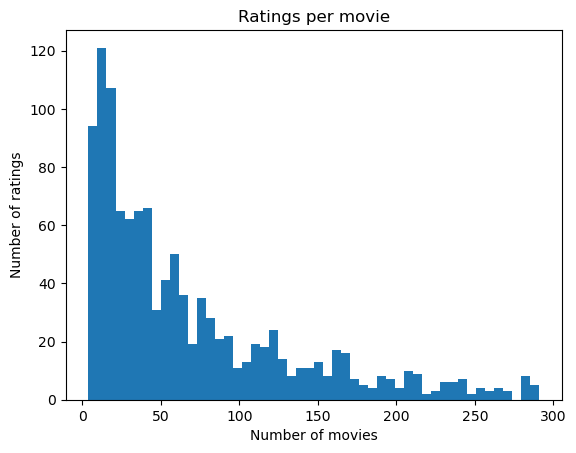

In [14]:
plt.title('Ratings per movie')
plt.xlabel("Number of movies")
plt.ylabel("Number of ratings")
plt.hist(removedOutliers.count(), bins= 50)

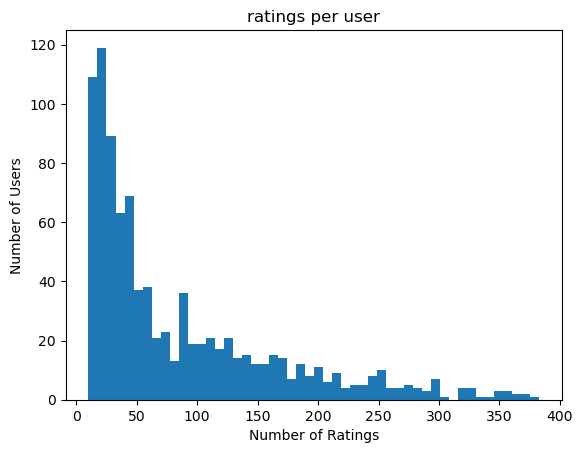

In [15]:
ratingsPerUser = removedOutliers.notnull().sum(axis=1)

ratingsPerUser.hist(bins=50)
plt.title('ratings per user')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(False)
plt.show()

# Q2: Basic Recommended System

## Spliting data into train and test ##

In [18]:
#random_state property allows for repitability of the spliting
trainData= removedOutliers.sample(frac=0.8,random_state=200, axis= 0)
testData= removedOutliers.drop(trainData.index)

In [19]:
#get the number of ratings a movie has
trainDataRatingsCount = trainData.notna().sum(axis= 0)
trainData

,2,3,4,5,6,8,9,10,11,12,...,1471,1473,1478,1480,1483,1503,1518,1540,1615,1620
userId,,,,,,,,,,,,,,,,,,,,,
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recomend movies to test users

In [21]:
# we recommend for each user seperately in order to be more flexible with the calculations

averageMovieRating = trainData.mean().sort_values(ascending= False)
recommendedMovies = pd.DataFrame()
for userIndex, row in testData.iterrows():  
    # if we want to recomend allready seen movies
    # notNanCols = row.dropna().index
    # sortedCols = averageMovieRating[notNanCols].sort_values(ascending=False).index[:10]
    
    #recommend the top 10 movies
    sortedCols = averageMovieRating.index[:10]
    topValues = averageMovieRating[sortedCols].values
    recommendedMovies.loc[userIndex, sortedCols] = topValues

# remove the warning
pd.set_option("future.no_silent_downcasting", True)
recommendedMovies = recommendedMovies.replace(b'', np.nan)
# testData.to_csv("testData.csv", sep=',', encoding='utf-8', index=True, header=True)
# averageMovieRating.to_csv("AMR.csv", sep=',', encoding='utf-8', index=True, header=True)
# recommendedMovies.to_csv("recommended.csv", sep=',', encoding='utf-8', index=True, header=True)

# Evaluate results using MAE, RMSE, precision, recall, and F1.

In [23]:
# calculate only for the values we predicted
alignedObservedDf, alignedCalculatedDF = testData.align(recommendedMovies)
validMask = ~alignedCalculatedDF.isna()
# validMask.to_csv("validMask.csv", sep=',', encoding='utf-8', index=True, header=True)
# remove NaN values
validOriginal = alignedObservedDf[validMask]
validCalculated = alignedCalculatedDF[validMask]


## MAE

In [25]:
# mean two times for the two axis
MAE = np.abs(validOriginal - validCalculated).mean().mean()
MAE

0.6008636727920661

## RMSE

In [27]:
meanSquaredError = ((validCalculated - validOriginal) ** 2).mean().mean()
RMSE = np.sqrt(meanSquaredError)
RMSE

0.7254250170067811

In [28]:
# calculate precision and recall nominator.
# seen movies that were recommended and the user rated them > 3.
wellRated = testData[testData >= 3]
alignedWellRated, alignedRecommended = wellRated.align(recommendedMovies)
validWellRatedMask = ~alignedWellRated.isna()
validRecommended = alignedRecommended[validWellRatedMask]

## Precision

In [30]:
precision = (validRecommended.notna().sum(axis= 1)/10).mean()
precision

0.13333333333333333

## Recall

In [32]:
recall = (validRecommended.notna().sum(axis= 1)/wellRated.notna().sum(axis= 1)).mean()
recall

0.020571099398505436

## F1 Score

In [34]:
f1Score = 2* ((precision* recall)/(precision+ recall))
f1Score

0.035643070241038514

# Q3: Collaborative Filtering: Recommender system

In [98]:
#libraries 


# Dbg = open("./DebugFile_cosineSimilarity.txt", "w")   # for debug file - to be deleted
# Dbg.write(' > > >  initiate')
# Dbg.close()
# Dbg =  open("./DebugFile_createSimilarityMatrix.txt", "w")   # for debug file - to be deleted
# Dbg.write(' > > >  initiate')
# Dbg.close()
# Dbg =  open("./DebugFile_predictR.txt", "w")   # for debug file - to be deleted
# Dbg.write(' > > >  initiate')
# Dbg.close()



def cosineSimilarity(u1, u2):
    #Find similarity between u1,u2 (two vectors - representing users) by finding the cosine of the angle between them
    #cosine = cosine is the ratio of the length of the adjacent side to that of the hypotenuse of a right angle triangle
    #similarity based on cosine -> 
    # dot product of vectors divaded by the product of the magmitudes 

    # Dbg =  open("DebugFile_cosineSimilarity.txt", "a")   # for debug file - to be deleted 
    # Dbg.write('\n')
    # Dbg.write('\n ----cosineSimilarity---------')
    # Dbg.write('\n u1,u2 => ' + str(u1) + ' , ' + str(u2))
    # Dbg.write('\n dot => ' + str(np.dot(u1, u2)))
    # Dbg.write('\n Hypotenus u1,u2 => ' + str(np.linalg.norm(u1)) + ' ... ' + str(np.linalg.norm(u2)))      
    # Dbg.write('\n ===============================')
    if (np.linalg.norm(u1) * np.linalg.norm(u2)) == 0 :
        # Dbg.write('\n !!!! Divide by zero !!!!!')
        return 9999999
    else:    
        return np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))

    # Dbg.close()

# Similarity matrix
def createSimilarityMatrix(df):
    #create couple of users (all combinations) and calculate with cosin similarity all cobinations

    # Dbg =  open("DebugFile_createSimilarityMatrix.txt", "a")   # for debug file - to be deleted
    # Dbg.write('\n')
    
    similarityMatrix = pd.DataFrame(index=df.index, columns=df.index) # output
    #iterate in all combinations
    for i in df.index: 
        for k in df.index:
            #similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
            if i == k:
                similarityMatrix.loc[i, k] = 1 # for the combination of the same user similarity is 1 by definition 
                # Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => 1 by definition') # ->> to be commened
            else:
                # Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => ' + str(cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0)))) # ->> to be commened
                similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
    # Dbg.close()            
    return similarityMatrix    


# Predict Ratings based on wated waited sum of all users rating for the movie
def predictR(df, similarityMatrix):
    # Dbg =  open("DebugFile_predictR.txt", "a")   # for debug file - to be deleted
    # Dbg.write('\n')
    
    predictRatings = df.copy() #create a copy for predictions
    for user in df.index:
        for movie in df.columns:
            if np.isnan(df.loc[user, movie]):
                similarU = similarityMatrix[user].drop(user).dropna() #check similarity with others - delete similarity with himself and any nulls
                similarU = similarU[similarU > 0] #keep positive similarity
                if not similarU.empty: #if similarity exists
                    weightedS = sum(df.loc[similarU.index, movie] * similarU) #calculates the waited sum of all users rating for the movie
                    # Dbg.write('\n @ ' + user + ',' + movie + ' => ' +str(weightedS))
                    similarityS = sum(similarU) #total similarities (to be used in the division)
                    predictRatings.loc[user, movie] = weightedS / similarityS #prediction based on the weighted sum of the ratings divided by the sum of the similarity scores
    # Dbg.close()
    return predictRatings

# Top x recommendations for each user
def topXrecommendations(predictRatings, x):
    recomm = {}
    for user in predictRatings.index:
        userR = predictRatings.loc[user]
        userR = userR[userR.notna()]
        topRecomm = userR.sort_values(ascending=False).head(x)
        recomm[user] = topRecomm.index.tolist()
    return recomm

def Find20ofData2Hide(Random20Hiden):
    # Selecting a random 20% of non-NaN values and returns "True" to "hide" them (all othe valuse are false
    
    # Selecting only non-NaN values
    NonNaNValues = Random20Hiden.stack().reset_index(drop=False)
    # Calculate the number of samples to select (20% of the non-NaN values to hide)
    num_samples = int(0.2 * len(NonNaNValues))
    
    # Select a random sample of the non-NaN values
    # random_state property allows for repeatability of the splitting
    random_sample20_indices = NonNaNValues.sample(n=num_samples, random_state=200).index

    #initialize dataframe with false
    Random20Hiden = pd.DataFrame(False,index = Random20Hiden.index, columns = Random20Hiden.columns)
    
    # Set the selected values to NaN (Hide them from system)
    for idx in random_sample20_indices:
        row_idx = NonNaNValues.loc[idx, 'userId']
        col_idx = NonNaNValues.loc[idx, 'level_1']
        Random20Hiden.at[row_idx, col_idx] = True
        
    return Random20Hiden



def findKSimilar (r, k,printx =False):
    # Find the k-most similar users for each user
    #
    # r is the ratings matrix
    # k is the number of most similar users
    #
    # returns: '
    #similarUsers: contains the indices of the most similar users to each user
    # similarities: is the pairwise similarities, i.e. similarities between users
    
    # similarUsers is 2-D matrix
    similarUsers=-1*np.ones((nUsers,k))
    
    similarities=cosine_similarity(r)
       
    # for each user
    
    # find the indexes of all  users similar to i, by increasing value of similarity
    for i in range(0, nUsers):
        simUsersIdxs= np.argsort(similarities[:,i])
        
        l=0
        #find its most similar users    
        for j in range(simUsersIdxs.size-2, simUsersIdxs.size-1-k-1,-1):
            if printx :
                    print(simUsersIdxs[-k+1:],l)
            similarUsers[i,l]=simUsersIdxs[j]
            l=l+1
            
    return similarUsers, similarities

def Top5RatedMovies(UserMovies):
    # it finds average rating of each movie and returns top 5 rated movies

    #calculate average per movie
    UserMoviesAVG = UserMovies[UserMovies.notna()].sum() / UserMovies[UserMovies.notna() ].count()
    

    

In [37]:
# Verification Libraries

def MAE(Original,Calculated,x,y):
    return np.abs(validOriginal[x:y] - validCalculated[x:y]).mean().mean()

def RMSE(Original,Calculated,x,y):
    meanSquaredError = ((validOriginal[x:y] - validCalculated[x:y]) ** 2).mean().mean()
    return np.sqrt(meanSquaredError)

#def precision(Original,Calculated,x,y):
#    precision = (validRecommended.notna().sum(axis= 1)/10).mean()
#    precision

#def recall(Original,Calculated,x,y):
#    recall = (validRecommended.notna().sum(axis= 1)/wellRated.notna().sum(axis= 1)).mean()
#    recall

#def f1Score():
#    f1Score = 2* ((precision* recall)/(precision+ recall))
#    f1Score

def Hide20Data(OriginalRating,IsHideDataframe):
    #returns a datafram with nan in evry cell that is hidden
    OriginalRating[IsHideDataframe] = np.nan

    return OriginalRating
 

In [86]:
#create test data

data = {
    'User1': [5, 2, 2, np.nan, np.nan],
    'User2': [np.nan, np.nan, np.nan, np.nan, np.nan],
    'User3': [4, 3, np.nan, np.nan, 5],
    'User4': [1, 2, np.nan, np.nan, 1],
    'User5': [1, 5, 5, np.nan, 1]
}
df = pd.DataFrame(data, index=['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5']).T

print('initial = ')
print(df)
print('final  = ')
isH= Find20ofData2Hide(df)
print(isH)
print('=====================')
print(Hide20Data(df,isH))





      
#print(Top5RatedMovies(df))

#similarity_matrix = createSimilarityMatrix(df) # Create similarity matrix


#predicted_ratings = predictR(df, similarity_matrix) # Predict ratings


#top_recommendations = topXrecommendations(predicted_ratings, 3) # Get top 3 recommendations for each user

#print("Original Ratings:")
#print(df)
#print("\nPredicted Ratings:")
#print(predicted_ratings)
#print("\nTop 3 Recommendations for Each User:")
#print(top_recommendations)




initial = 
       Movie1  Movie2  Movie3  Movie4  Movie5
User1     5.0     2.0     2.0     NaN     NaN
User2     NaN     NaN     NaN     NaN     NaN
User3     4.0     3.0     NaN     NaN     5.0
User4     1.0     2.0     NaN     NaN     1.0
User5     1.0     5.0     5.0     NaN     1.0
final  = 
   level_0 level_1    0
0    User1  Movie1  5.0
1    User1  Movie2  2.0
2    User1  Movie3  2.0
3    User3  Movie1  4.0
4    User3  Movie2  3.0
5    User3  Movie5  5.0
6    User4  Movie1  1.0
7    User4  Movie2  2.0
8    User4  Movie5  1.0
9    User5  Movie1  1.0
10   User5  Movie2  5.0
11   User5  Movie3  5.0
12   User5  Movie5  1.0
       Movie1  Movie2  Movie3  Movie4  Movie5
User1   False   False   False   False   False
User2   False   False   False   False   False
User3   False   False   False   False    True
User4   False   False   False   False   False
User5   False   False   False   False    True
       Movie1  Movie2  Movie3  Movie4  Movie5
User1     5.0     2.0     2.0     NaN     NaN

## 1.The collaborative system will be based on user similarity

In [40]:
# Predict Ratings based on wated waited sum of all users rating for the movie
def predictR(df, similarityMatrix):
    #Dbg =  open("DebugFile_predictR.txt", "a")   # for debug file - to be deleted
    #Dbg.write('\n')
    
    predictRatings = df.copy() #create a copy for predictions
    for user in df.index:
        for movie in df.columns:
            if np.isnan(df.loc[user, movie]):
                similarU = similarityMatrix[user].drop(user).dropna() #check similarity with others - delete similarity with himself and any nulls
                similarU = similarU[similarU > 0] #keep positive similarity
                if not similarU.empty: #if similarity exists
                    weightedS = sum(df.loc[similarU.index, movie] * similarU) #calculates the waited sum of all users rating for the movie
                    #Dbg.write('\n @ ' + user + ',' + movie + ' => ' +str(weightedS))
                    similarityS = sum(similarU) #total similarities (to be used in the division)
                    predictRatings.loc[user, movie] = weightedS / similarityS #prediction based on the weighted sum of the ratings divided by the sum of the similarity scores
    #Dbg.close()
    return predictRatings

# Top x recommendations for each user
def topXrecommendations(predictRatings, x):
    recomm = {}
    for user in predictRatings.index:
        userR = predictRatings.loc[user]
        userR = userR[userR.notna()]
        topRecomm = userR.sort_values(ascending=False).head(x)
        recomm[user] = topRecomm.index.tolist()
    return recomm

## 2.User based similarity will be based on cosine similarity

In [42]:
def cosineSimilarity(u1, u2):
    #Find similarity between u1,u2 (two vectors - representing users) by finding the cosine of the angle between them
    #cosine = cosine is the ratio of the length of the adjacent side to that of the hypotenuse of a right angle triangle
    #similarity based on cosine -> 
    # dot product of vectors divaded by the product of the magmitudes 

    #Dbg =  open("DebugFile_cosineSimilarity.txt", "a")   # for debug file - to be deleted 
    #Dbg.write('\n')
    #Dbg.write('\n ----cosineSimilarity---------')
    #Dbg.write('\n u1,u2 => ' + str(u1) + ' , ' + str(u2))
    #Dbg.write('\n dot => ' + str(np.dot(u1, u2)))
    #Dbg.write('\n Hypotenus u1,u2 => ' + str(np.linalg.norm(u1)) + ' ... ' + str(np.linalg.norm(u2)))      
    #Dbg.write('\n ===============================')
    if (np.linalg.norm(u1) * np.linalg.norm(u2)) == 0 :
        #Dbg.write('\n !!!! Divide by zero !!!!!')
        return 9999999
    else:    
        return np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))

    #Dbg.close()

# Similarity matrix
def createSimilarityMatrix(df):
    #create couple of users (all combinations) and calculate with cosin similarity all cobinations

    #Dbg =  open("DebugFile_createSimilarityMatrix.txt", "a")   # for debug file - to be deleted
    #Dbg.write('\n')
    
    similarityMatrix = pd.DataFrame(index=df.index, columns=df.index) # output
    #iterate in all combinations
    for i in df.index: 
        for k in df.index:
            #similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
            if i == k:
                similarityMatrix.loc[i, k] = 1 # for the combination of the same user similarity is 1 by definition 
                #Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => 1 by definition') # ->> to be commened
            else:
                #Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => ' + str(cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0)))) # ->> to be commened
                similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
    #Dbg.close()            
    return similarityMatrix    

## 3.Generate the top-5 recommendations per user

In [46]:
similarity_matrix = createSimilarityMatrix(removedOutliers.sample(frac=0.1,random_state=200, axis= 0)) # Create similarity matrix

In [50]:
predicted_ratings = predictR(removedOutliers.sample(frac=0.1,random_state=200, axis= 0), similarity_matrix) # Predict ratings

In [141]:
top_recommendations = topXrecommendations(predicted_ratings, 5) # Get top 3 recommendations for each user
similarity_matrix

userId,797,182,700,903,600,772,74,691,633,913,...,406,907,278,380,556,30,351,735,357,789
userId,,,,,,,,,,,,,,,,,,,,,
797,1,0.0,0.0,0.0,0.018201,0.147817,0.128576,0.008985,0.034837,0.0,...,0.0,0.060346,0.0,0.015179,0.083085,0.056497,0.145966,0.085332,0.017689,0.0
182,0.0,1,0.152897,0.145857,0.0,0.0,0.120188,0.068244,0.052917,0.100588,...,0.12383,0.136353,0.0,0.072244,0.142667,0.0,0.0,0.115217,0.220331,0.123748
700,0.0,0.152897,1,0.144911,0.088456,0.0,0.0,0.072779,0.25395,0.247228,...,0.155292,0.114559,0.0,0.118846,0.117037,0.122029,0.0,0.0,0.0,0.0
903,0.0,0.145857,0.144911,1,0.150722,0.0431,0.144191,0.104798,0.172679,0.304104,...,0.360947,0.19927,0.04476,0.339312,0.224983,0.009884,0.0,0.161449,0.08665,0.154705
600,0.018201,0.0,0.088456,0.150722,1,0.0,0.0,0.050536,0.231306,0.202868,...,0.159907,0.026516,0.093683,0.242672,0.028218,0.129455,0.0,0.029625,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.056497,0.0,0.122029,0.009884,0.129455,0.181444,0.098322,0.026144,0.099249,0.070245,...,0.075404,0.014632,0.116316,0.096916,0.066567,1,0.135979,0.190809,0.028593,0.050649
351,0.145966,0.0,0.0,0.0,0.0,0.486142,0.146742,0.04266,0.079252,0.067546,...,0.008959,0.105948,0.147095,0.035032,0.057169,0.135979,1,0.121915,0.095648,0.0
735,0.085332,0.115217,0.0,0.161449,0.029625,0.191722,0.352546,0.026325,0.065915,0.111149,...,0.119418,0.203502,0.102481,0.045705,0.07232,0.190809,0.121915,1,0.156913,0.323845


## 4.Evaluation

### a. Randomly hide 20% of the interactions’ matrix (users in rows, movies in columns). That is hide 20% of the cells.

In [247]:
hiddenData = Find20ofData2Hide(removedOutliers.sample(frac=0.1,random_state=200, axis= 0))
hiddenData.to_csv('hiddenValuesExport.csv')

predictionData = pd.DataFrame()

for index, row in hiddenData.iterrows():
    # Check if any value in the row is True
    if row.any():  
        # row.idxmax()  
        similarUserIds = similarity_matrix[index].drop(index = index).sort_values(ascending = False).head(5)
        similarUsers = removedOutliers.loc[pd.Series(similarUserIds.index.values)]
        predictionData.loc[index, row.idxmax()] = similarUsers[row.idxmax()].dropna().mean()

predictionData

,340,150,28,4,22,322,124,182,5,12,...,326,48,301,321,66,923,135,242,123,137
797,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,NaN,NaN,3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,NaN,NaN,NaN,3.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.333333,NaN,NaN
351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN


### b. Experiment with different user thresholds (e.g., only users with more than 20 ratings are used in predictions).

### c. Additional Features: Incorporate additional features (e.g., movie genres, timestamps, user demographic data) in recommendations

# Q4: Improvements: